In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import epidemic_model_classes_numba as epi_mod
from ABC_backend_numba import *
from data_loading import LoadData
from proj_consts import ProjectConsts

log_paths = ["../logs/log2021-03-22_18-10-19_DF_SEIRD_True_10/", "../logs/log2021-03-22_10-05-12_DF_SEIRD_True_20/", 
             "../logs/log2021-03-22_08-08-44_DF_SEIRD_True_30/", "../logs/log2021-03-23_12-17-16_DF_SEIRD_True_40/", 
             "../logs/log2021-03-23_01-16-57_DF_SEIRD_True_50/"]
# log_labels = ["Flat prior", "Last window posterior"]

data_path = open("data_path.txt", "r").read()
df_brazil_state_cases = pd.read_csv(data_path)

In [2]:
locations = open(r"locationsIN.txt", "r").read().split("\n")[:-1]
# models = open(r"modelsIN.txt", "r").read().split("\n")[:1]
models = ["SEIRD2"]#, "SEIHRD", "SEIARD"]
print(locations)
print(models)

['DF']
['SEIRD2']


In [3]:
n_post = 0
for file in os.listdir(log_paths[0]):
    
    if ("Posterior" in file):
        n_post += 1
        
print(n_post)

5


In [4]:
day_step = 5
day_set_size = 50
val_set_size = 10
day_start = 0

data = LoadData.getBrazilStateDataFrame(df_brazil_state_cases, locations[0])
x_total = np.array(data.day, dtype=np.float64)

days_sets_set = []
days_list = []

for i in range(len(log_paths)):
    
    day_set_size = int(log_paths[i][-3:-1])
    days = []
    
    n_sets = int((len(data)-day_set_size-val_set_size) // day_step)
    
    for l in range(n_sets):

        if (l*day_step+day_set_size >= day_start):

            days.append(l*day_step+day_set_size)

    days_sets = []

    if (day_step == 0):

        days_sets.append(x_total)

    else:

        for k in range((len(x_total)-day_set_size-val_set_size)//day_step):

            days_sets.append(x_total[day_step*k:day_step*k+day_set_size])

    for k in range(len(days_sets)):

        if (days_sets[k][-1] >= day_start+x_total[0]-1):

            start_idx = k
            break
            
    days_sets_set.append(days_sets)
    days_list.append(days)

In [5]:
rmsd_train_list = np.zeros((len(log_paths), len(days)))
rmsd_val_list = np.zeros((len(log_paths), len(days)))
rmsd_val_comb = np.zeros((len(days)))
error = np.zeros((len(log_paths), len(days), 2, val_set_size))

pred_val = np.zeros((len(log_paths), len(days), 2, val_set_size))
dat_y_val = np.zeros((len(days), 2, val_set_size))

model = getattr(epi_mod, models[0])

for idx in range(len(days)):
    for log in range(len(log_paths)):
        
        days_sets = days_sets_set[log]
        idx_fix = days_list[log].index(days_list[-1][0])
        days_idx = idx+idx_fix
        
        filepath =  f"../logs/{log_paths[log]}Posterior{n_post}/{locations[0]}/{models[0]}/{days_list[log][days_idx]}_days"
        p = np.genfromtxt(filepath+"/best_params.txt")
        weights = np.array([1, 1], dtype=np.float64)
        
        x = days_sets[days_idx]
        x_val = (days_sets[days_idx]+val_set_size)[-val_set_size:]
        x_dat_val = np.concatenate((x, x_val))
        y = np.array(data[["confirmed", "dead"]].T, dtype=np.float64)[:,days_sets[days_idx].astype(np.int)-int(days_sets[0][0])]
        y_val = np.array(data[["confirmed", "dead"]].T, dtype=np.float64)[:,(days_sets[days_idx]+val_set_size)[-val_set_size:].astype(np.int)-int(days_sets[0][0])]
        y_dat_val = np.concatenate((y, y_val), axis=1)
        
        y0 = np.zeros(model.ncomp, dtype=np.float64)
        y0[-1] = data.loc[int(days_sets[days_idx][0]-days_sets[0][0]),["dead"]]
        y0[-2] = data.loc[int(days_sets[days_idx][0]-days_sets[0][0]),["confirmed"]]-y0[-1]
        
        pred_val[log, idx] = model.infected_dead(x_dat_val, p, y0)[:,-val_set_size:]
        error[log, idx] = np.abs(pred_val[log, idx]-y_val)
        
        rmsd_train_list[log, idx] = distance(y, model.infected_dead(x, p, y0), weights)
        rmsd_val_list[log, idx] = distance(y_dat_val[:,-val_set_size:], pred_val[log, idx], weights)
    
    dat_y_val[idx] = y_val
#     if idx == 0:
    rmsd_val_comb[idx] = distance(y_val, np.average(pred_val[:,idx], axis=0, weights=1/rmsd_train_list[:, idx]), weights)
#     else:
#         rmsd_val_comb[idx] = distance(y_val, np.average(pred_val[:,idx], axis=0, weights=1/rmsd_val_list[:, idx-1]**2), weights)
    print(f"\r{days_idx+1}/{len(days)}", end="")
    


61/61

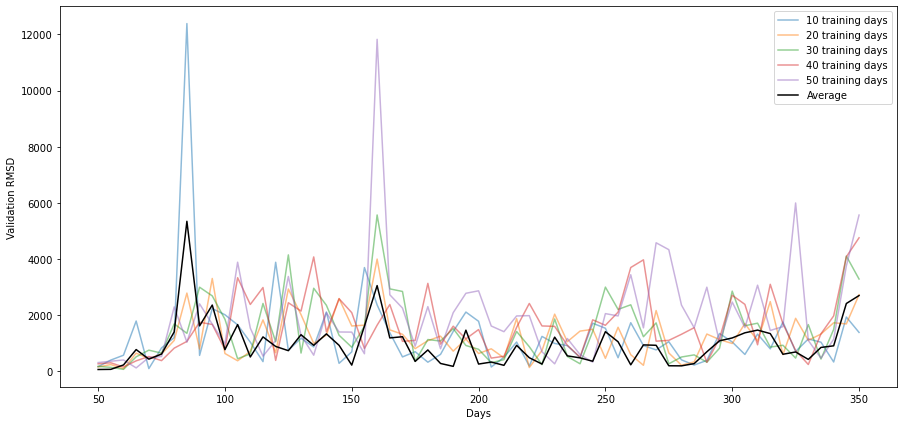

In [6]:
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    
    plt.plot(days, rmsd_val_list[i], alpha=0.5, label=log_paths[i][-3:-1]+" training days")
plt.xlabel("Days")
plt.ylabel("Validation RMSD")
plt.plot(days, rmsd_val_comb, c="k", label="Average")
plt.legend()
plt.show()

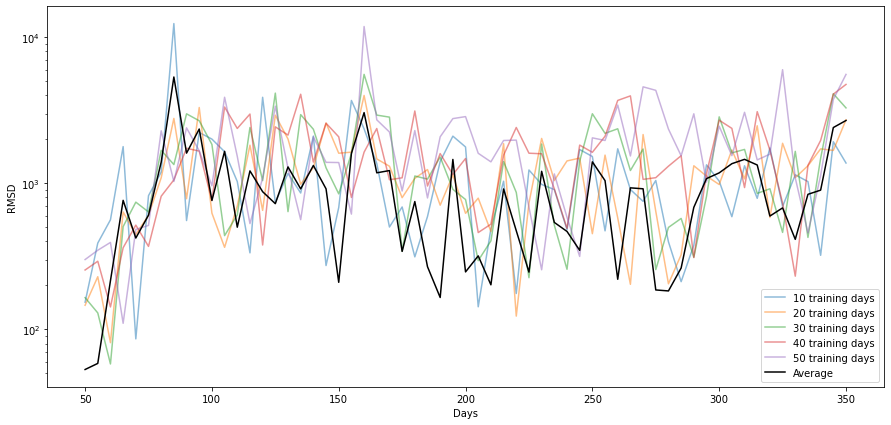

In [7]:
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    
    plt.plot(days, rmsd_val_list[i], alpha=0.5, label=log_paths[i][-3:-1]+" training days")
plt.xlabel("Days")
plt.ylabel("RMSD")
plt.plot(days, rmsd_val_comb, c="k", label="Average")
plt.legend()
plt.yscale("log")
plt.show()

In [8]:
len(np.where(rmsd_val_comb < np.min(rmsd_val_list, axis=0))[0])/len(rmsd_val_comb)*100

24.59016393442623

Best Validation RMSD for 10 days window: 31.1%
Best Validation RMSD for 20 days window: 23.0%
Best Validation RMSD for 30 days window: 23.0%
Best Validation RMSD for 40 days window: 13.1%
Best Validation RMSD for 50 days window: 9.8%


Text(0, 0.5, 'Training window size with best validation RMSD')

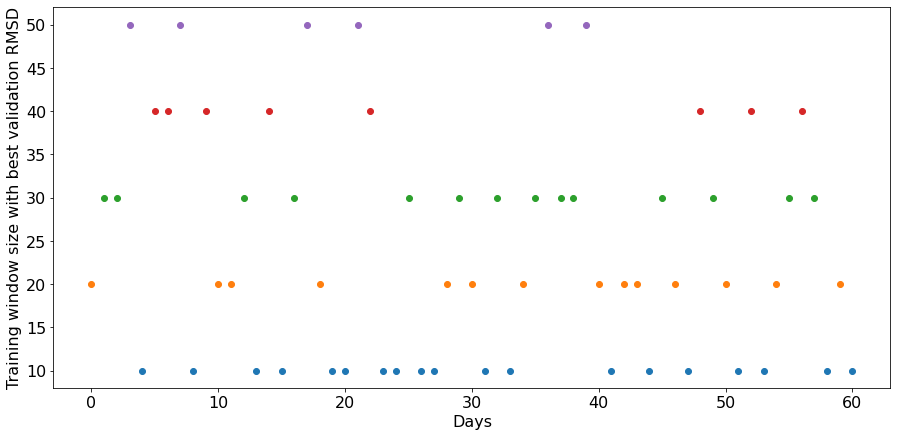

In [9]:
plt.rcParams.update({'font.size': 16})
# rmsd_train_min = np.array(np.where(rmsd_train_list == np.min(rmsd_train_list, axis=0)))
# plt.figure(figsize=(15,7))
# for i in range(len(log_paths)):
#     plt.scatter(rmsd_train_min[1][np.where(rmsd_train_min[0] == i)[0]], [int(log_paths[i][-3:-1]) for j in range(len(np.where(rmsd_train_min[0] == i)[0]))])
#     print(f"Best Train RMSD for {log_paths[i][-3:-1]} days window: {len(np.where(rmsd_train_min[0] == i)[0])/len(days)*100:.1f}%")
# plt.xlabel("Days")
# plt.ylabel("Windows with best ")

rmsd_val_min = np.array(np.where(rmsd_val_list == np.min(rmsd_val_list, axis=0)))
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    plt.scatter(rmsd_val_min[1][np.where(rmsd_val_min[0] == i)[0]], [int(log_paths[i][-3:-1]) for j in range(len(np.where(rmsd_val_min[0] == i)[0]))])
    print(f"Best Validation RMSD for {log_paths[i][-3:-1]} days window: {len(np.where(rmsd_val_min[0] == i)[0])/len(days)*100:.1f}%")
plt.xlabel("Days")
plt.ylabel("Training window size with best validation RMSD")

In [10]:
tols = np.zeros((len(log_paths), len(days_list[0]), n_post))
tol_median = np.zeros((len(log_paths), len(days_list[0]), n_post))
tol_bounds = np.zeros((len(log_paths), len(days_list[0]), n_post, 2))

for i in range(len(log_paths)):
    for j in range(len(days_list[i])):
        for k in range(0, n_post):
            
            filepath =  f"{log_paths[i]}Posterior{k+1}/{locations[0]}/{models[0]}/{days_list[i][j]}_days"
            
            logfile = open(filepath+"/SEIRD_log.out").read().split("\n")
            post_tols = np.genfromtxt(filepath+"/post.txt")[:,-1]
            for line in logfile:
                
                if "Tolerance:" in line:
#                     print("\t"+line.split(" ")[-1])
                    tols[i,j,k] = line.split(" ")[-1]
                    tol_median[i,j,k] = np.median(post_tols)
                    tol_bounds[i,j,k,0] = np.min(post_tols)
                    tol_bounds[i,j,k,1] = np.max(post_tols)
                    break
            
            print(f"\r{i+1}/{len(log_paths)}, {j+1}/{len(days_list[i])}, {k+1}/{n_post}", end="")

5/5, 61/61, 5/5

In [11]:
log_paths = ["../logs/log2021-03-22_13-42-53_DF_SEIRD_False_10/", "../logs/log2021-03-22_12-08-16_DF_SEIRD_False_20/", 
             "../logs/log2021-03-22_01-58-50_DF_SEIRD_False_30/", "../logs/log2021-03-23_10-39-37_DF_SEIRD_False_40/", 
             "../logs/log2021-03-23_09-17-39_DF_SEIRD_False_50/"]
# log_labels = ["Flat prior", "Last window posterior"]

data_path = open("data_path.txt", "r").read()
df_brazil_state_cases = pd.read_csv(data_path)

In [12]:
locations = open(r"locationsIN.txt", "r").read().split("\n")[:-1]
# models = open(r"modelsIN.txt", "r").read().split("\n")[:1]
models = ["SEIRD2"]#, "SEIHRD", "SEIARD"]
print(locations)
print(models)

['DF']
['SEIRD2']


In [13]:
n_post = 0
for file in os.listdir(log_paths[0]):
    
    if ("Posterior" in file):
        n_post += 1
        
print(n_post)

5


In [14]:
day_step = 5
day_set_size = 50
val_set_size = 10
day_start = 0

data = LoadData.getBrazilStateDataFrame(df_brazil_state_cases, locations[0])
x_total = np.array(data.day, dtype=np.float64)

days_sets_set = []
days_list = []

for i in range(len(log_paths)):
    
    day_set_size = int(log_paths[i][-3:-1])
    days = []
    
    n_sets = int((len(data)-day_set_size-val_set_size) // day_step)
    
    for l in range(n_sets):

        if (l*day_step+day_set_size >= day_start):

            days.append(l*day_step+day_set_size)

    days_sets = []

    if (day_step == 0):

        days_sets.append(x_total)

    else:

        for k in range((len(x_total)-day_set_size-val_set_size)//day_step):

            days_sets.append(x_total[day_step*k:day_step*k+day_set_size])

    for k in range(len(days_sets)):

        if (days_sets[k][-1] >= day_start+x_total[0]-1):

            start_idx = k
            break
            
    days_sets_set.append(days_sets)
    days_list.append(days)

In [15]:
rmsd_train_list = np.zeros((len(log_paths), len(days)))
rmsd_val_list = np.zeros((len(log_paths), len(days)))
rmsd_val_comb2 = np.zeros((len(days)))
error = np.zeros((len(log_paths), len(days), 2, val_set_size))

pred_val = np.zeros((len(log_paths), len(days), 2, val_set_size))
dat_y_val = np.zeros((len(days), 2, val_set_size))

model = getattr(epi_mod, models[0])

for idx in range(len(days)):
    for log in range(len(log_paths)):
        
        days_sets = days_sets_set[log]
        idx_fix = days_list[log].index(days_list[-1][0])
        days_idx = idx+idx_fix
        
        filepath =  f"../logs/{log_paths[log]}Posterior{n_post}/{locations[0]}/{models[0]}/{days_list[log][days_idx]}_days"
        p = np.genfromtxt(filepath+"/best_params.txt")
        weights = np.array([1, 1], dtype=np.float64)
        
        x = days_sets[days_idx]
        x_val = (days_sets[days_idx]+val_set_size)[-val_set_size:]
        x_dat_val = np.concatenate((x, x_val))
        y = np.array(data[["confirmed", "dead"]].T, dtype=np.float64)[:,days_sets[days_idx].astype(np.int)-int(days_sets[0][0])]
        y_val = np.array(data[["confirmed", "dead"]].T, dtype=np.float64)[:,(days_sets[days_idx]+val_set_size)[-val_set_size:].astype(np.int)-int(days_sets[0][0])]
        y_dat_val = np.concatenate((y, y_val), axis=1)
        
        y0 = np.zeros(model.ncomp, dtype=np.float64)
        y0[-1] = data.loc[int(days_sets[days_idx][0]-days_sets[0][0]),["dead"]]
        y0[-2] = data.loc[int(days_sets[days_idx][0]-days_sets[0][0]),["confirmed"]]-y0[-1]
        
        pred_val[log, idx] = model.infected_dead(x_dat_val, p, y0)[:,-val_set_size:]
        error[log, idx] = np.abs(pred_val[log, idx]-y_val)
        
        rmsd_train_list[log, idx] = distance(y, model.infected_dead(x, p, y0), weights)
        rmsd_val_list[log, idx] = distance(y_dat_val[:,-val_set_size:], pred_val[log, idx], weights)
    
    dat_y_val[idx] = y_val
#     if idx == 0:
    rmsd_val_comb2[idx] = distance(y_val, np.average(pred_val[:,idx], axis=0, weights=1/rmsd_train_list[:, idx]), weights)
#     else:
#         rmsd_val_comb[idx] = distance(y_val, np.average(pred_val[:,idx], axis=0, weights=1/rmsd_val_list[:, idx-1]**2), weights)
    print(f"\r{days_idx+1}/{len(days)}", end="")
    


61/61

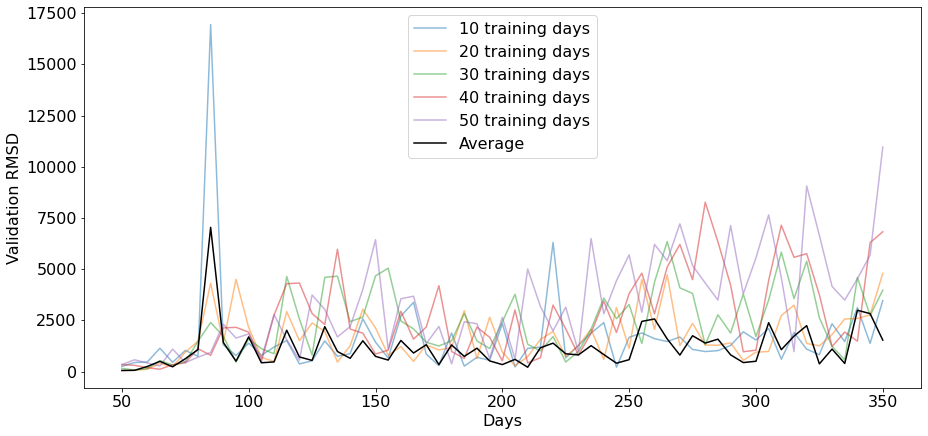

In [16]:
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    
    plt.plot(days, rmsd_val_list[i], alpha=0.5, label=log_paths[i][-3:-1]+" training days")
plt.xlabel("Days")
plt.ylabel("Validation RMSD")
plt.plot(days, rmsd_val_comb2, c="k", label="Average")
plt.legend()
plt.show()

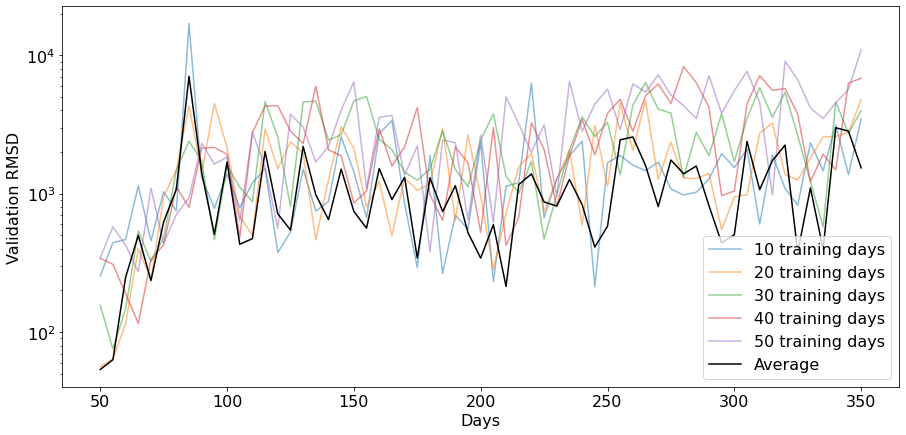

In [17]:
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    
    plt.plot(days, rmsd_val_list[i], alpha=0.5, label=log_paths[i][-3:-1]+" training days")
plt.xlabel("Days")
plt.ylabel("Validation RMSD")
plt.plot(days, rmsd_val_comb2, c="k", label="Average")
plt.legend()
plt.yscale("log")
plt.show()

In [18]:
len(np.where(rmsd_val_comb2 < np.min(rmsd_val_list, axis=0))[0])/len(rmsd_val_comb2)*100

37.704918032786885

Best Validation RMSD for 10 days window: 42.6%
Best Validation RMSD for 20 days window: 24.6%
Best Validation RMSD for 30 days window: 8.2%
Best Validation RMSD for 40 days window: 19.7%
Best Validation RMSD for 50 days window: 4.9%


Text(0, 0.5, 'Training window size with best validation RMSD')

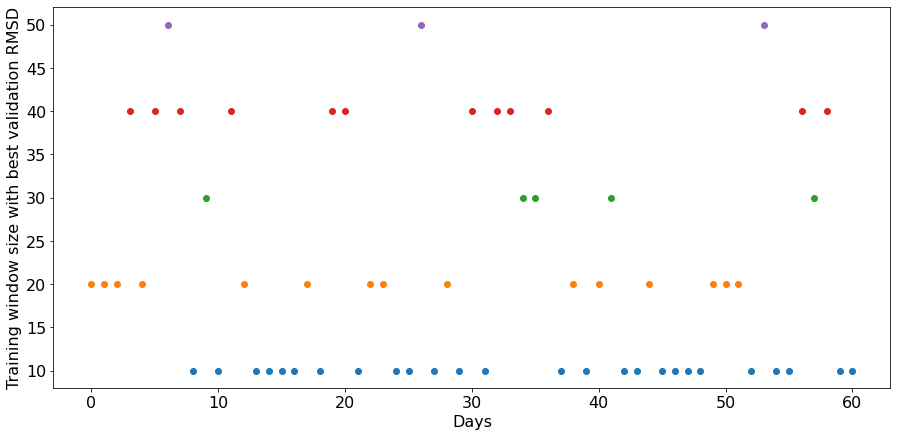

In [19]:
rmsd_val_min = np.array(np.where(rmsd_val_list == np.min(rmsd_val_list, axis=0)))
plt.figure(figsize=(15,7))
for i in range(len(log_paths)):
    plt.scatter(rmsd_val_min[1][np.where(rmsd_val_min[0] == i)[0]], [int(log_paths[i][-3:-1]) for j in range(len(np.where(rmsd_val_min[0] == i)[0]))])
    print(f"Best Validation RMSD for {log_paths[i][-3:-1]} days window: {len(np.where(rmsd_val_min[0] == i)[0])/len(days)*100:.1f}%")
plt.xlabel("Days")
plt.ylabel("Training window size with best validation RMSD")

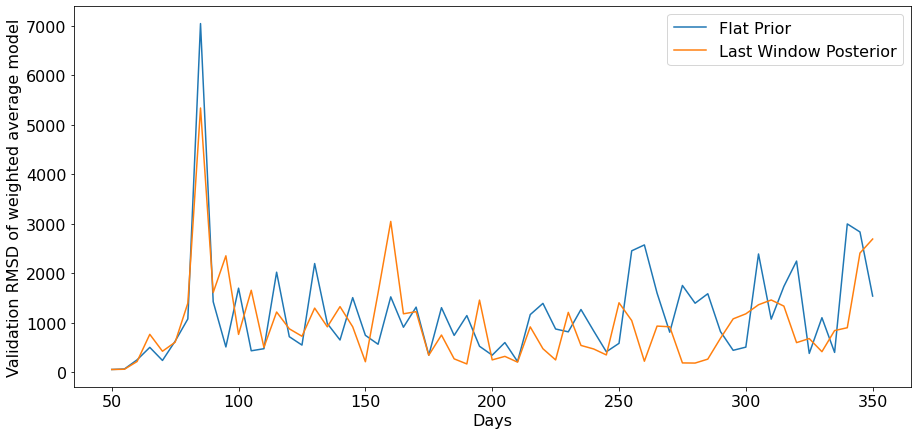

62.295081967213115


In [20]:
plt.figure(figsize=(15,7))
plt.plot(days, rmsd_val_comb2, label="Flat Prior")
plt.plot(days, rmsd_val_comb, label="Last Window Posterior")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Validation RMSD of weighted average model")
plt.show()
print(len(np.where(rmsd_val_comb < rmsd_val_comb2)[0])/len(rmsd_val_comb)*100)

In [21]:
tols2 = np.zeros((len(log_paths), len(days_list[0]), n_post))
tol_median2 = np.zeros((len(log_paths), len(days_list[0]), n_post))
tol_bounds2 = np.zeros((len(log_paths), len(days_list[0]), n_post, 2))

for i in range(len(log_paths)):
    for j in range(len(days_list[i])):
        for k in range(0, n_post):
            
            filepath =  f"{log_paths[i]}Posterior{k+1}/{locations[0]}/{models[0]}/{days_list[i][j]}_days"
            
            logfile = open(filepath+"/SEIRD_log.out").read().split("\n")
            post_tols = np.genfromtxt(filepath+"/post.txt")[:,-1]
            
            for line in logfile:
                
                if "Tolerance:" in line:
#                     print("\t"+line.split(" ")[-1])
                    tols2[i,j,k] = line.split(" ")[-1]
                    tol_median2[i,j,k] = np.median(post_tols)
                    tol_bounds2[i,j,k,0] = np.min(post_tols)
                    tol_bounds2[i,j,k,1] = np.max(post_tols)
                    break
            
            print(f"\r{i+1}/{len(log_paths)}, {j+1}/{len(days_list[i])}, {k+1}/{n_post}", end="")

5/5, 61/61, 5/5

In [22]:
plt.rcParams.update({'font.size': 16})
for i in range(len(log_paths)):
    plt.figure(figsize=(30, 10))
    plt.imshow(np.log10(tols[i][:len(days_list[i])]).T, cmap="coolwarm", aspect=5)
    plt.yticks(np.arange(5), np.arange(1,6))
    plt.colorbar(pad=0.01)
    plt.title(f"Tolerance - {log_paths[i][-3:-1]} days windows")
    plt.xlabel("Days")
    plt.ylabel("Posterior")
    plt.savefig(f"tolerace_heatmap_{log_paths[i][-3:-1]}.pdf", format="pdf")
    plt.close()

In [23]:
plt.rcParams.update({'font.size': 16})
for i in range(len(log_paths)):
    plt.figure(figsize=(30, 10))
    plt.imshow(np.log10(tols2[i][:len(days_list[i])]).T, cmap="coolwarm", aspect=5)
    plt.yticks(np.arange(5), np.arange(1,6))
    plt.colorbar(pad=0.01)
    plt.title(f"Tolerance - {log_paths[i][-3:-1]} days windows")
    plt.xlabel("Days")
    plt.ylabel("Posterior")
    plt.savefig(f"tolerace_heatmap_{log_paths[i][-3:-1]}_flat.pdf", format="pdf")
    plt.close()

In [27]:
plt.rcParams.update({'font.size': 10})

for j in range(len(log_paths)):
    plt.subplots(10,7, figsize=(40,28))
    plt.suptitle(f"Tolerances - {log_paths[j][-3:-1]} days windows", y=1.)

    for i in range(len(days_list[j])):
        plt.subplot(7,10,i+1)
#         plt.plot(np.arange(1, n_post+1), tols[j][i], "-o")
        plt.errorbar(np.arange(1, n_post+1), tol_median[j,i], tol_bounds[j,i].T, fmt="-o", capsize=7)
        plt.title(f"Window {i+1}")

    for i in range(len(days_list[j]), 70):
        plt.subplot(7,10,i+1)
        plt.axis("off")

    plt.suptitle(f"{log_paths[j][-3:-1]} days windows", y=0.93, fontsize=30)
    plt.savefig(f"tolerances_{log_paths[j][-3:-1]}.pdf", format="pdf")
    plt.close()

In [28]:
plt.rcParams.update({'font.size': 10})

for j in range(len(log_paths)):
    plt.subplots(10,7, figsize=(40,28))

    for i in range(len(days_list[j])):
        plt.subplot(7,10,i+1)
#         plt.plot(np.arange(1, n_post+1), tols2[j][i], "-o")
        plt.errorbar(np.arange(1, n_post+1), tol_median2[j,i], tol_bounds2[j,i].T, fmt="-o", capsize=7)
        plt.title(f"Window {i+1}")


    for i in range(len(days_list[j]), 70):
        plt.subplot(7,10,i+1)
        plt.axis("off")
    
    plt.suptitle(f"{log_paths[j][-3:-1]} days windows", y=0.93, fontsize=30)
    plt.savefig(f"tolerances_{log_paths[j][-3:-1]}_flat.pdf", format="pdf")
    plt.close()

In [29]:
plt.rcParams.update({'font.size': 10})

for j in range(len(log_paths)):
    plt.subplots(10,7, figsize=(40,28))

    for i in range(len(days_list[j])):
        plt.subplot(7,10,i+1)
#         plt.plot(np.arange(1, n_post+1), tols2[j][i], "-o")
#         plt.plot(np.arange(1, n_post+1), tols[j][i], "-o")
        plt.errorbar(np.arange(1, n_post+1), tol_median2[j,i], tol_bounds2[j,i].T, fmt="-o", capsize=7)
        plt.errorbar(np.arange(1, n_post+1), tol_median[j,i], tol_bounds[j,i].T, fmt="-o", capsize=7)
        plt.title(f"Window {i+1}")
    #     plt.title()

    for i in range(len(days_list[j]), 70):
        plt.subplot(7,10,i+1)
        plt.axis("off")
        
    plt.suptitle(f"{log_paths[j][-3:-1]} days windows. Blue = flat prior; orange = last window posterior", y=0.93, fontsize=30)
    plt.savefig(f"tolerances_{log_paths[j][-3:-1]}_comparison.pdf", format="pdf")
    plt.close()